## Linear models Lasso and Ridge hyperparameter tuning by GPyOpt <br>
Reference : <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/

### Import library and dataset

In [1]:
%matplotlib inline
%pylab inline  
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Matrics
from sklearn.metrics import mean_squared_error, r2_score

# Cross validation
from sklearn.model_selection import KFold, ShuffleSplit

# Hyperparameter tunig
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load dataset
df = pd.read_csv('glass.csv')
print(df.shape)
df.head()

(214, 11)


,Id number,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_test = df.drop(df.columns[[0, 10]], axis=1)
print(df_test.shape)
df_test.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [4]:
X = df_test.iloc[:, 1:]
y = df_test.iloc[:, :1]

In [5]:
print(X.shape)
X.head()

(214, 8)


,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


In [6]:
print(y.shape)
y.head()

(214, 1)


,RI
0,1.52101
1,1.51761
2,1.51618
3,1.51766
4,1.51742


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(171, 8) (43, 8) (171, 1) (43, 1)


### Lasso regression - default

In [11]:
lr = Lasso()
lr.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
print('coefficient = ', lr.coef_)
print('intercept   = ', lr.intercept_)

coefficient =  [-0. -0. -0. -0. -0.  0.  0.  0.]
intercept   =  [1.51848298]


In [13]:
pred_lr = lr.predict(X_test)
R2_lr = r2_score(pred_lr, y_test)
print('R2 = ', R2_lr)

R2 =  0.0


### Ridge regression - default

In [14]:
rr = Ridge()
rr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [15]:
print('coefficient = ', rr.coef_)
print('intercept   = ', rr.intercept_)

coefficient =  [[ 0.00032293  0.00074113 -0.00101055 -0.00100701  0.00031143  0.00199948
   0.00173889 -0.00011847]]
intercept   =  [1.56829512]


In [16]:
pred_rr = rr.predict(X_test)
R2_rr = r2_score(pred_rr, y_test)
print('R2 = ', R2_rr)

R2 =  0.8896169002563661


### Hyperparameter tuning using GPyOpt

optimized alpha =  [0.17508683]


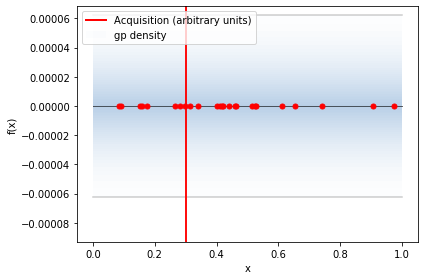

In [17]:
# GPyOpt for Lasso

bounds_L = [
    {'name': 'alpha', 'type': 'continuous','domain': (0, 1)}
]

# Optimization objective 
def rmse_comp_L(bounds):
    lr = Lasso(alpha = bounds, normalize = True)               # model = Lasso
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    RMSE_ = np.sqrt(mean_squared_error(pred_lr, y_test))
    return RMSE_

optimizer = BayesianOptimization(f = rmse_comp_L, domain = bounds_L)

optimizer.run_optimization(max_iter = 20)

print('optimized alpha = ', optimizer.x_opt)
optimizer.plot_acquisition()

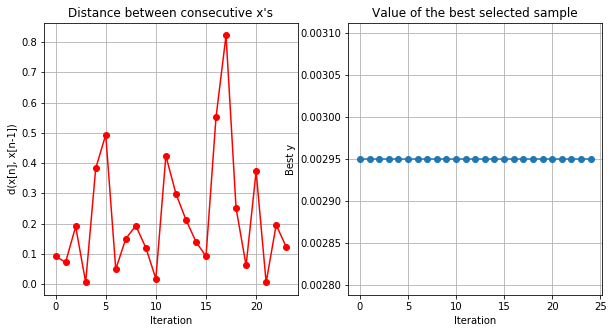

In [18]:
optimizer.plot_convergence()

optimized alpha =  [0.]


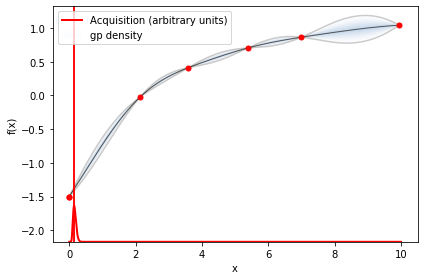

In [19]:
# GPyOpt for Ridge

bounds_R = [
    {'name': 'alpha', 'type': 'continuous','domain': (0, 10)}
]

# Optimization objective 
def rmse_comp_R(bounds):
    lr = Ridge(alpha = bounds, normalize = True)        # model = Ridge
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    RMSE_ = np.sqrt(mean_squared_error(pred_lr, y_test))
    return RMSE_

optimizer = BayesianOptimization(f = rmse_comp_R, domain = bounds_R)

optimizer.run_optimization(max_iter = 20)

print('optimized alpha = ', optimizer.x_opt)
optimizer.plot_acquisition()

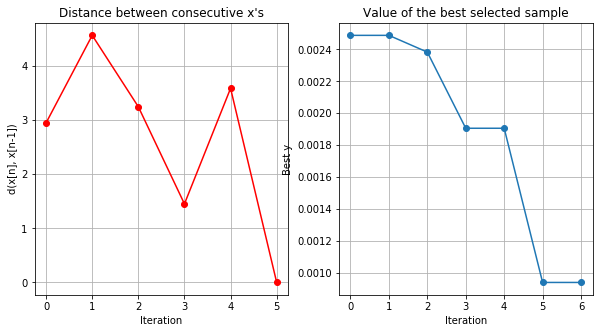

In [20]:
optimizer.plot_convergence()

### Scores of KFold and Shaffle split

In [21]:
split_num = 5

In [22]:
# Lasso
alpha_L = []
CV_R2_L = []

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    optimizer = BayesianOptimization(f = rmse_comp_L, domain = bounds_L)
    optimizer.run_optimization(max_iter = 20)

    lr_k_fold = Lasso(alpha = optimizer.x_opt, normalize = True)
    lr_k_fold.fit(X_train, y_train)
    pred_lr_k_fold = lr_k_fold.predict(X_test)
    R2 = r2_score(pred_lr_k_fold, y_test)
    print('optimized alpah = ', optimizer.x_opt, 'R2 = ', R2)
    alpha_L.append(optimizer.x_opt)
    CV_R2_L.append(R2)

print('Average R2 Lasso = ', np.mean(CV_R2_L))

optimized alpah =  [0.00247125] R2 =  0.0
optimized alpah =  [0.17667548] R2 =  -2.627173562215925e+26
optimized alpah =  [0.23100739] R2 =  0.0
optimized alpah =  [0.79281369] R2 =  0.0
optimized alpah =  [0.26394088] R2 =  -1.870685463131503e+26
Average R2 Lasso =  -8.995718050694856e+25


In [23]:
best_R2_idx = argmax(CV_R2_L)
best_R2 = CV_R2_L[best_R2_idx]
best_alpha_L = alpha_L[best_R2_idx]
print('best_R2_idx, best_R2, best_alpha_L', best_R2_idx, best_R2, best_alpha_L)

best_R2_idx, best_R2, best_alpha_L 0 0.0 [0.00247125]


In [24]:
# Ridge
alpha_R = []
CV_R2_R = []

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    optimizer = BayesianOptimization(f = rmse_comp_R, domain = bounds_R)
    optimizer.run_optimization(max_iter = 20)

    rr_k_fold = Ridge(alpha = optimizer.x_opt, normalize = True)
    rr_k_fold.fit(X_train, y_train)
    pred_rr_k_fold = rr_k_fold.predict(X_test)
    R2 = r2_score(pred_rr_k_fold, y_test)
    print('optimized alpah = ', optimizer.x_opt, 'R2 = ', R2)
    alpha_R.append(optimizer.x_opt)
    CV_R2_R.append(R2)

print('Average R2 Ridge = ', np.mean(CV_R2_R))

optimized alpah =  [0.0571676] R2 =  0.9488246335176335
optimized alpah =  [0.] R2 =  0.887918575820957
optimized alpah =  [0.] R2 =  0.6698063080592842
optimized alpah =  [0.11000033] R2 =  0.7958622492980721
optimized alpah =  [0.] R2 =  0.8451874490064093
Average R2 Ridge =  0.8295198431404712


In [25]:
best_R2_idx = argmax(CV_R2_R)
best_R2 = CV_R2_R[best_R2_idx]
best_alpha_R = alpha_R[best_R2_idx]
print('best_R2_idx, best_R2, best_alpha_R = ', best_R2_idx, best_R2, best_alpha_R)

best_R2_idx, best_R2, best_alpha_R =  0 0.9488246335176335 [0.0571676]


### See how the model fits

R2 =   0.0


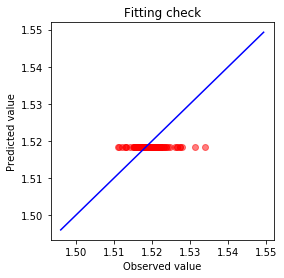

In [26]:
# Lasso
X_train, y_train = X, y
lr_best = Lasso(alpha = best_alpha_L, normalize = True)      # model = Lasso
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

R2 =   0.8888


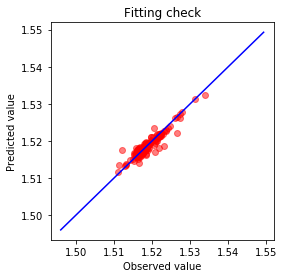

In [27]:
# Ridge
X_train, y_train = X, y
rr_best = Ridge(alpha = best_alpha_R, normalize = True)      # model = Ridge
rr_best.fit(X_train, y_train)
y_pred = rr_best.predict(X)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import (KFold, ShuffleSplit)
split_num = 5

cv_KF = KFold(n_splits = split_num, shuffle = True, random_state = 0)

print('Check best model perfromance in the original folds')
for train_index, test_index in cv_KF.split(X):
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index]
    y_pred = rr_best.predict(X_test)
    R2_reg = r2_score(y_test, y_pred)
    print(' {:.4}'.format(R2_reg))

Check best model perfromance in the original folds
 0.9525
 0.9003
 0.7781
 0.8615
 0.8844
